In [ ]:
import pandas as pd
import torch as torch
import numpy as np
from scipy.stats import zscore
from torch.utils.data import DataLoader,Dataset, TensorDataset, random_split
import math
import matplotlib.pyplot as plt

In [ ]:
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Load the iris dataset using pandas
data = pd.read_csv('/iris.csv')
x_data = data[list(data.columns)[0:-1]].apply(zscore).to_numpy()
y_data = pd.get_dummies(data['variety']).to_numpy()

In [ ]:
# no. of classes, features, and samples
n_classes = 3
n_features = x_data.shape[1]

In [ ]:
# convert data and labels into tensors
t_x_data=torch.tensor(x_data,requires_grad=False,device=device)
t_y_data=torch.tensor(y_data,requires_grad=False,device=device)

In [ ]:
# combain data and labels into a tensor dataset
dataset = TensorDataset(t_x_data, t_y_data)

In [ ]:
# create train and test split
train_size = int(len(dataset)*0.8)
test_size = len(dataset)-train_size
train_data,test_data = random_split(dataset,[train_size,test_size])

In [ ]:
#creats data loader for training data
batch_size=100
dL_train = DataLoader(train_data, batch_size= batch_size,shuffle=True)
dL_test = DataLoader(test_data,batch_size=len(test_data))

In [ ]:
#define starting value of weights W for gradient descent
# W = n_features* n_classes
init_std_dev = 0.01;
initialW=init_std_dev*np.random.randn(n_features,n_classes)

In [ ]:
def softmax(x):
    e_x = torch.exp(x - torch.max(x))
    return e_x / e_x.sum(axis=1, keepdims=True)

In [ ]:
# create a PyTorch tensor variable for W and b. 
# we will be optimizing over W, b, finding their best value using gradient descent,so we need gradient enabled
W = torch.tensor(initialW,requires_grad=True,device=device);
# the shape of b = 1*n_classes
b = torch.zeros((1,n_classes),requires_grad=True,device=device);

In [ ]:
# this optimizer will do gradient descent for us
learning_rate = 0.01;
optimizer = torch.optim.SGD([W,b],lr=learning_rate)
#optimizer = torch.optim.Adam([W,b],lr=learning_rate)

In [ ]:
n_epochs = 10000
loss = []
t_accuracy = []
for i in range(n_epochs):
  accuracy = 0
  batches= 0
  running_loss = 0.0
  for j ,data in enumerate(dL_train):
    batches += 1
    inputs,labels = data
    # clear previous gradient calculations
    optimizer.zero_grad();
    # calculate model predictions
    linear_predictions = torch.matmul(inputs,W)+b
    #map prediction outputs into specific valuse using that sum to one (softmax function)
    activations = softmax(linear_predictions)
    #calculate loss(using cross entropy)
    prediction_error = -torch.sum(torch.multiply(labels,torch.log(activations)),axis =1)
    risk =torch.mean(prediction_error)
    #calculate gradients of risk w.r.t. W,b and propagate them back
    risk.backward();
    # use the gradient to change W, b
    optimizer.step()
    running_loss +=risk.item()
    # calculate accuracy (on the training set!)
    true_class = np.argmax(labels.detach().cpu().numpy(),axis=1)
    pred_class = np.argmax(activations.detach().cpu().numpy(),axis=1)
    accuracy += np.count_nonzero(true_class == pred_class)/pred_class.shape[0];
    error = 1.0 - accuracy;
  loss.append(running_loss/batches)
  t_accuracy.append(accuracy/batches)
  print('Epoch: [{:}/{:}]\t loss: {:.3f}\t accuracy: {:.3f}'.format(i+1,n_epochs,running_loss/batches,accuracy/batches))


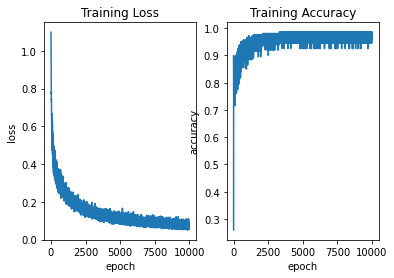

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(loss,'-')
plt.title('Training Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.subplot(1, 2, 2)
plt.plot(t_accuracy)
plt.title('Training Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()



In [ ]:
#testing model
for k, data in enumerate(dL_test):
    inputs,labels = data
    # calculate model predictions
    linear_predictions = torch.matmul(inputs,W)+b
    #map prediction outputs into specific valuse using that sum to one (softmax function)
    activations = softmax(linear_predictions)
    #calculate loss(using cross entropy)
    prediction_error = -torch.sum(torch.multiply(labels,torch.log(activations)),axis =1)
    risk =torch.mean(prediction_error)
    # calculate accuracy (on the training set!)
    true_class = np.argmax(labels.detach().cpu().numpy(),axis=1)
    pred_class = np.argmax(activations.detach().cpu().numpy(),axis=1)
    accuracy = np.count_nonzero(true_class == pred_class)/pred_class.shape[0];
    error = 1.0 - accuracy;
    print('loss: {:.3f}\t accuracy: {:.3f}'.format(risk.item(),accuracy))

loss: 0.173	 accuracy: 0.933


# HW2.3 Report:
The code has been experimented using different parameters such as batch size, learning_rate, epochs and init_std_dev. In each experiment same parameter setup is used for both optimizers(Adam and SGD) to see how they behave. The results was collected and compared for analysis purpose. The following is some findings from the results:
# Observations:
1. SGD needs more iterations and larger learning rates compared to Adam.
2. Adam always showes smaller loss and reaches minimum values faster than SGD.
3. Adam outperforms SGD. It has larger accuracy and smaller loss.
4. Both optimizers give best results using 0.01 learning rate and 0.01 init_std_dev with different batch sizes and different iterations in training.
5. Both optimizers give best results at training and testing using 10000 epoches, 0.01 learning rate, and 0.01 init_std_dev with different batch sizes. 